Dots in middle panel: numerical differentiation of psi
Dots in bottom panel: numerical differentiation of dpsi


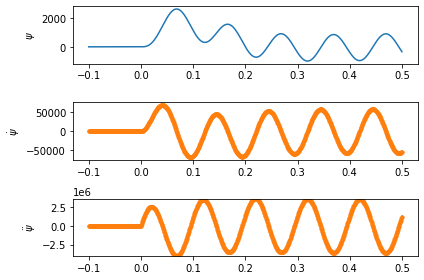

In [1]:
# Sphere solution with transient
import numpy as np
import matplotlib.pyplot as plt

# Mode: prod | test
# prod for comparing results to a relevant test case
# test for a test problem with distinct transient and harmonic behaviours
mode:str = "prod"

if mode == 'test':
  # Background density
  rho = 1.2
  # Sound speed
  c = 343
  # Sphere radius
  a = 0.01
  # Sphere oscillation amplitude
  u0 = 1
  # Sphere oscillation frequency
  w = 100
else:
  # Background density
  rho = 1e5 / (287 * 300)
  # Sound speed
  c = np.sqrt(1.4 * 287 * 300)
  # Sphere radius
  a = 30
  # Sphere oscillation amplitude
  u0 = 1
  # Sphere oscillation angular frequency
  w = 10 * (2 * np.pi)

# Natural frequency of ODE. Note: this is a linear frequency
fn = c / a
prefactor = fn * fn * a*a*a * u0
def psi(t):
  t = np.clip(t, 0, None)
  numerator = (w**3 * np.exp(-fn * t) * np.sin(fn * t)
              - w**2 * fn * np.sin(w * t)
              + 2 * fn**3 * np.sin(w * t)
              - 2 * w * fn**2 * np.cos(w * t)
              + 2 * w * fn**2 * np.exp(-fn * t) * np.cos(fn * t))
  denom = w**5 * fn + 4 * w * fn**5
  return np.where(t > 0,
                  prefactor * w * (numerator / denom),
                  0)

def dpsi(t):
  t = np.clip(t, 0, None)
  numerator = (w**3 * fn * (-np.exp(-fn * t) * np.sin(fn * t) + np.exp(-fn * t) * np.cos(fn * t))
              - w**3 * fn * np.cos(w * t)
              + 2 * w * fn**3 * np.cos(w * t)
              + 2 * w**2 * fn**2 * np.sin(w * t)
              + 2 * w * fn**3 * (-np.exp(-fn * t) * np.cos(fn * t) - np.exp(-fn * t) * np.sin(fn * t)))
  denom = w**5 * fn + 4 * w * fn**5
  return np.where(t > 0,
                  prefactor * w * (numerator / denom),
                  0)

def RHS(t):
  return np.where(t > 0,
                  c * c * a * u0 * np.sin(w*t),
                  0)

def ddpsi(t):
  return RHS(t) - 2 * fn * dpsi(t) - 2 * fn * fn * psi(t)

t_range = np.linspace(-1, 5, 1200) * 2 * np.pi / w
dt = t_range[1] - t_range[0]
t_range_mean = 0.5 * (t_range[1:] + t_range[:-1])
fig, ax = plt.subplots(3,1)

ax[0].plot(t_range, psi(t_range))
ax[0].set_ylabel(r"$\psi$")
ax[1].plot(t_range, dpsi(t_range))
ax[1].plot(t_range_mean, np.diff(psi(t_range))/ dt, '.')
ax[1].set_ylabel(r"$\dot{\psi}$")
ax[2].plot(t_range, ddpsi(t_range))
ax[2].plot(t_range_mean, np.diff(dpsi(t_range))/ dt, '.')
ax[2].set_ylim(ddpsi(t_range).min(), ddpsi(t_range).max())
ax[2].set_ylabel(r"$\ddot{\psi}$")
plt.tight_layout()
print("Dots in middle panel: numerical differentiation of psi")
print("Dots in bottom panel: numerical differentiation of dpsi")

The potential function is associated with a transient (scale T_n), 
followed by the forced oscillation (T_omega).


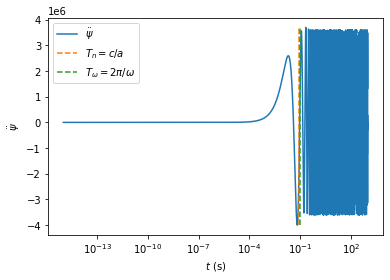

In [2]:
test_t_range = np.geomspace(1e-15,1e3,6000)
test_ddpsi_range = ddpsi(test_t_range)
plt.semilogx(test_t_range, test_ddpsi_range)
# Natural wave period of lengthscale a
Tn = 1 / fn
plt.plot(Tn * np.array([1, 1]), np.array([test_ddpsi_range.min(), test_ddpsi_range.max()]), '--')
plt.plot(2 * np.pi / w * np.array([1, 1]), np.array([test_ddpsi_range.min(), test_ddpsi_range.max()]), '--')
plt.gca().set_ylabel(r"$\ddot{\psi}$")
plt.xlabel("$t$ (s)")
plt.legend([r"$\ddot{\psi}$", r"$T_n = c / a$",r"$T_\omega = 2 \pi / \omega$"])
print("The potential function is associated with a transient (scale T_n), ")
print("followed by the forced oscillation (T_omega).")

In [3]:
wavelength = 2 * np.pi * c / w
wavelength

34.71887094938429

Left column: before wave arrival
Right column: after wave arrival
r = 100 = 2.880277994805399 wavelengths.
Transient is underresolved. 


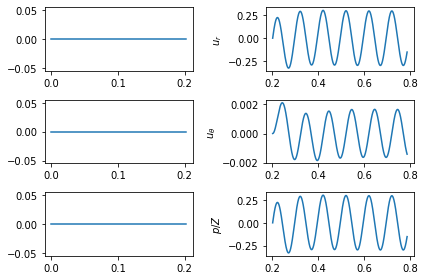

In [4]:
r = 100
theta = 0.1

t_range_noncausal = np.linspace(0, (r - a) / c, 1000)
t_range_causal = np.linspace((r - a) / c, 5 * (2 * np.pi) / w + r / c, 5000)

def field(r, theta, t) -> tuple:
  t_lag = t - (r-a)/c
  _psi = psi(t_lag)
  _dpsi = dpsi(t_lag)
  _ddpsi = ddpsi(t_lag)
  u_r = np.cos(theta) * (2 * _psi / (r*r*r) + _dpsi / (r*r*c) + _ddpsi / (r*c*c))
  u_th = -np.sin(theta) / r * (-_psi / (r*r) - _dpsi / (r*c))
  p = - rho * np.cos(theta) * (-_dpsi/(r * r) - _ddpsi/(r*c))
  return (p, u_r, u_th)

p, u_r, u_th = field(r, theta, t_range_noncausal)
plt.subplot(3,2,1)
plt.plot(t_range_noncausal, u_r)
plt.subplot(3,2,3)
plt.plot(t_range_noncausal, u_th)
plt.subplot(3,2,5)
plt.plot(t_range_noncausal, p)

p, u_r, u_th = field(r, theta, t_range_causal)
plt.subplot(3,2,2)
plt.plot(t_range_causal, u_r)
plt.ylabel("$u_r$")
plt.subplot(3,2,4)
plt.plot(t_range_causal, u_th)
plt.ylabel(r"$u_\theta$")
plt.subplot(3,2,6)
plt.plot(t_range_causal, p / (rho*c))
plt.ylabel("$p / Z$")

plt.tight_layout()
print("Left column: before wave arrival")
print("Right column: after wave arrival")
print(f"r = {r} = {r/wavelength} wavelengths.")

print("Transient is underresolved. ")


Comparing calculated solution with steady approx for ka << 1.
Transient (solid line) is underresolved and clipped in the vertical axis.


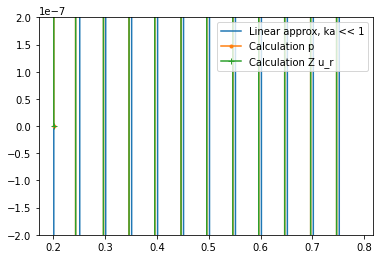

In [5]:
plt.plot(t_range_causal, -w * w * rho / c * (0.5 * a**3 * u0) * np.cos(theta) * np.sin(w*(t_range_causal - (r-a)/c)) / r)
plt.plot(t_range_causal, p, '.-')
plt.plot(t_range_causal, u_r * rho * c, '+-')
# plt.xlim(left=0.295)
plt.ylim(-.2e-6, .2e-6)
plt.legend(["Linear approx, ka << 1", "Calculation p", "Calculation Z u_r"])
print("Comparing calculated solution with steady approx for ka << 1.")
print("Transient (solid line) is underresolved and clipped in the vertical axis.")

t = 0.742857142857148 s
Wavelength: 34.71887094938429 m


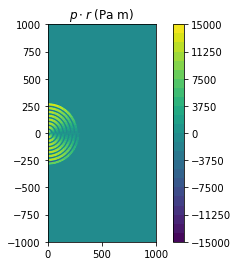

In [6]:
# Plot solution field (for mode 'prod')
if mode != "test":
  x_range = np.linspace(0, 1000, 800)
  y_range = np.linspace(-1000, 1000, 800)
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x) + np.pi/2 # Rotate to +y initial movement

  # t = 1000 / 343
  t = 0.742857142857148

  p, u_r, u_theta = field(r, theta, t)

  plt.contourf(x_range, y_range, p * r, levels=np.linspace(-15e3, 15e3, 25))

  plt.colorbar()
  plt.title(r"$p \cdot r$ (Pa m)")
  print(f"t = {t} s")
  print(f"Wavelength: {wavelength} m")
  plt.gca().set_aspect('equal')

In [7]:
# Plot solution field
if mode == "test":
  x_range = np.linspace(-2, 2, 800) * wavelength
  y_range = np.linspace(-2, 2, 800) * wavelength
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x)

  t = 0.100
  p, u_r, u_theta = field(r, theta, t)

  plt.contourf(x_range, y_range, p * r * 1e6, levels=np.linspace(-50, 50, 100))

  plt.colorbar()
  plt.title(r"$p \cdot r$ ($\mu$Pa m)")
  print(f"t = {t} s")
  print(f"Wavelength: {wavelength} m")

In [8]:
# Plot solution field for transient
if mode == "test":
  window_size = 100 * a
  x_range = np.linspace(-window_size, window_size, 800)
  y_range = np.linspace(-window_size, window_size, 800)
  mg_x, mg_y = np.meshgrid(x_range, y_range)
  r = np.sqrt(mg_x**2 + mg_y**2)
  theta = np.arctan2(mg_y, mg_x)

  t = 80/fn
  p, u_r, u_theta = field(r, theta, t)

  # Compute micro pascal meter, masking away data inside the sphere
  mg_z = np.where(r > a, p * r * 1e6, np.nan)
  # Mask out 
  plt.contourf(x_range, y_range, mg_z, levels=np.linspace(-8000, 8000, 300))
  plt.colorbar()
  plt.title(r"$p \cdot r$ ($\mu$Pa m)")

  # Plot sphere
  theta_range = np.linspace(0, 2*np.pi, 9900+1)[:-1]
  plt.plot(a * np.cos(theta_range), a * np.sin(theta_range), 'k-')

  print(f"t = {t} s")
  print(f"Transient pressure wave from initial acceleration. ")